In [33]:
%matplotlib inline

In [34]:
import re
import os
import codecs
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
#from os import *
#import keras
#import pandas as pd
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
from __future__ import unicode_literals

In [35]:
nlp=spacy.load('en')

In [36]:
#infra_path = os.path.join("data", "error_classification", "tocheck.txt")
#infra_path = os.path.join("data", "error_classification", "sample.txt")
# infra_path = os.path.join("data", "error_classification", "InfraRELATEDCHECK.txt")
# user_path = os.path.join("data", "error_classification", "USERRELATEDCHECK1.txt")
import json
import csv
intent_dict = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}

#intent_dict = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}

def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            X.append(row[0])
            y.append(intent_dict[row[1]])
    return X,y
        
ubuntu_data_path = os.path.join("datasets","NLU-Evaluation-Corpora","AskUbuntuCorpus.json")

with open(ubuntu_data_path) as f:
    ubuntu_data = json.load(f)
    
sentences = ubuntu_data["sentences"]

corpus = []
y = []

for sentence in sentences:
    corpus.append(sentence["text"])
    y.append(intent_dict[sentence["intent"]])
# infra_data = [l.strip() for l in codecs.open(infra_path, "r", "utf-8")]
# user_data = [l.strip() for l in codecs.open(user_path, "r", "utf-8")]

#infra_data=codecs.open(infra_path,"r","utf-8")

#print len(serialize2)

X_train_raw, y_train_raw = read_CSV_datafile(filename = "datasets/KL/Ubuntu/train_new.csv")
X_test_raw, y_test_raw = read_CSV_datafile(filename = "datasets/KL/Ubuntu/test.csv")


In [37]:
print("corpus_data: \n",corpus[-5:-1], "\n\n")


print("y: \n", y[-5:-1], "\n\n")

print("Size of Corpus: {}\nSize of y: {}".format(len(corpus), len(y)))

corpus_data: 
 ['Are there any Keyboard Shortcuts to Shutdown?', 'Shutdown after a certain time', 'Shutdown problem in Ubuntu 16.04', 'How do I fix a shutdown problem?'] 


y: 
 [2, 2, 2, 2] 


Size of Corpus: 162
Size of y: 162


In [38]:
def stratified_split(X, y, n_splits=5, test_size=0.66):
    skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=0)
    skf.get_n_splits(X, y)
    splits = []
    for train_index, test_index in skf.split(X, y):
        print("TRAIN:", train_index, "\n\n", "TEST:", test_index, "\n\n")
        X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
        splits.append({"train": {"X": X_train, "y": y_train},
                       "test": {"X": X_test, "y": y_test}})
    return splits
#print X_train[1]

In [39]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #      token.shape_, token.is_alpha, token.is_stop)
        #if not token.is_stop:
        #    clean_tokens.append(token.lemma_)
        tokens.append(token.text)
    return tokens


def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #      token.shape_, token.is_alpha, token.is_stop)
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
        #clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

# SemHash

In [40]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

corpus = semhash_corpus(corpus)

X_train_raw = semhash_corpus(X_train)
X_test_raw = semhash_corpus(X_test)

In [41]:
corpus[:5]

['#wh wha hat at# #so sof oft ftw twa war are re# #-P -PR PRO RON ON- N-# #us use se# #vi vie iew ew# #ep epu pub ub# #do doc ocu cum ume men ent nt# #?#',
 '#wh whi hic ich ch# #pd pdf df# #vi vie iew ewe wer er# #re rec eco com omm mme men end nd# #?#',
 '#wh wha hat at# #id ide de# #av ava vai ail ila lab abl ble le# #ub ubu bun unt ntu tu# #?#',
 '#wh wha hat at# #be be# #go goo ood od# #mi min ind nd# #ma map app ppi pin ing ng# #so sof oft ftw twa war are re# #?#',
 '#so sof oft ftw twa war are re# #re rea ead ad# #qr qr# #co cod ode de# #?#']

In [42]:
clean_doc = preprocess("I was flying a kite when the man in the blue shirt tried to steal my wallet")
print(clean_doc)
#type(clean_doc)

-PRON- fly kite man blue shirt try steal wallet


In [43]:
tokens_from_clean_text = tokenize(clean_doc)
print(tokens_from_clean_text)
#type(tokens_from_clean_text)

['-PRON-', 'fly', 'kite', 'man', 'blue', 'shirt', 'try', 'steal', 'wallet']


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [45]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [46]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import cross_val_score

In [47]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time
    #avg=cross_val_score(clf,corpus,y,cv=5)
#print avg

In [48]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

In [49]:
def get_X_andy_from_split():
    # train_corpus, y_train = split["train"]["X"], split["train"]["y"]
    # test_corpus, y_test = split["test"]["X"], split["test"]["y"]
    vectorizer, feature_names = get_vectorizer(X_train_raw, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train = vectorizer.transform(X_train_raw).toarray()
    X_test = vectorizer.transform(X_test_raw).toarray()
    
    #for i,label in enumerate(y_train):
     #   if label == 4:
      #      y_train = np.append(y_train,[4], axis=0)
       #     X_train = np.append(X_train,X_train[i], axis=0)
            
    return X_train, y_train, X_test, y_test, feature_names
#print feature_names



In [50]:
splits = stratified_split(corpus, y, n_splits=5, test_size=0.66)

TRAIN: [123 151  27 143  79 103  62 119  81 108   8  25  61 154 125  83 137 116
 133  80  17  85   4  49  33 134  38 138 130  16 129 161   7  19 105  84
  87  70 152  52 109  93 150   1 160 127  74 146  32 117   6  12  44  54
  82] 

 TEST: [149 114  43 111  46  57  26 148 113  28  13   0  21 145  90  76 115  22
  40  39  58 112  94  42 124  65 110  23 147  89 156 107  88 142 141 118
  11   9  60  24  37  14  63  66  64  51  41  36 140  78 101  98  72  47
  35 153 102 128 104  75 131  59 106  20 132  10  97 144 159   3  91   5
 126  18  55  96  15  95  50 136  56 157  48 158  73  34 120  77  53 100
 155  69  68  86 122  99 139   2  45  30 121 135  67  29  92  71  31] 


TRAIN: [  6 102  51 151 123  56 104  77  70 100 149   2  73  94 113 147  60  97
  26 111  11  95  37  58  12 161  92  86  18  14  52 121  89  34 144  41
 127 134 132  96  83  47  88   8  63  55 131 159  38 118  40   5  31 135
  66] 

 TEST: [128 105  87  13 138  98  27  53 148 155   0 125  20  33 119   1  23 139
  82  3

Evaluating Split 0
Train Size: 61
Test Size: 109
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.059s
test time:  0.022s
accuracy:   0.890
dimensionality: 4858
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.97      0.96        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.94      0.75      0.83        40
                   None       0.36      0.80      0.50         5

            avg / total       0.92      0.89      0.90       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 30  7]
 [ 0

/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 1.961s
test time:  0.041s
accuracy:   0.743
classification report:
                         precision    recall  f1-score   support

            Make Update       0.91      0.86      0.89        37
          Setup Printer       0.53      0.69      0.60        13
      Shutdown Computer       0.67      0.86      0.75        14
Software Recommendation       0.96      0.62      0.76        40
                   None       0.23      0.60      0.33         5

            avg / total       0.82      0.74      0.76       109

confusion matrix:
[[32  3  1  0  1]
 [ 0  9  1  0  3]
 [ 0  0 12  1  1]
 [ 3  3  4 25  5]
 [ 0  2  0  0  3]]

gridsearchmlp
________________________________________________________________________________
Training: 
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='cons

/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.248s
test time:  0.001s
accuracy:   0.899
dimensionality: 4858
density: 0.665294

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.78      1.00      0.88        14
Software Recommendation       0.94      0.82      0.88        40
                   None       1.00      0.20      0.33         5

            avg / total       0.91      0.90      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  3 33  0]
 [ 0  1  1  2  1]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=50, n_iter=None,
  

/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.242s
test time:  0.001s
accuracy:   0.826
dimensionality: 4858
density: 0.600659

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.84      0.89        37
          Setup Printer       0.62      1.00      0.76        13
      Shutdown Computer       0.74      1.00      0.85        14
Software Recommendation       0.94      0.75      0.83        40
                   None       0.50      0.40      0.44         5

            avg / total       0.85      0.83      0.83       109

confusion matrix:
[[31  5  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  2  4 30  2]
 [ 0  1  1  1  2]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.001s
test time:  0.001s
accuracy:   0.578
classification report:
                         precision    reca

/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/home/insideout/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


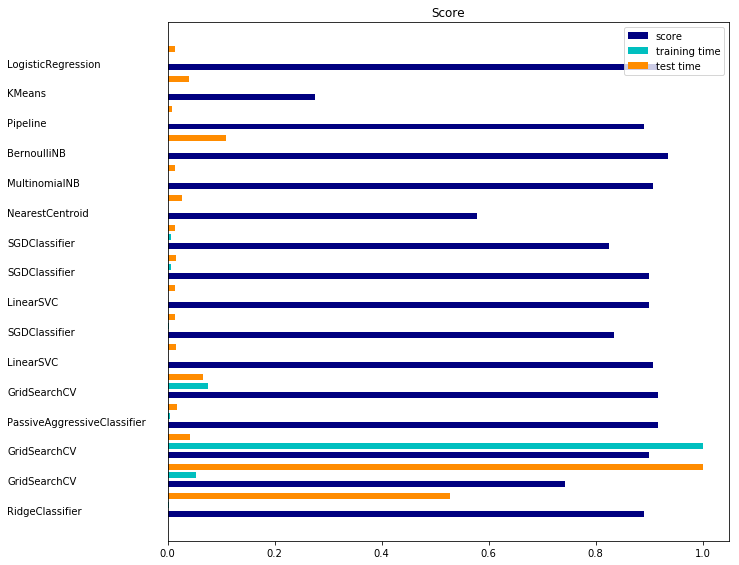

In [51]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(range(1)):
    print("Evaluating Split {}".format(i_s))
    X_train, y_train, X_test, y_test, feature_names = get_X_andy_from_split()
    target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50),(300,100,50),(200,100),(500,300,100,50)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 2]}
    k_range = list(range(1, 11))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            (GridSearchCV(knn,parameters_knn, cv=10),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            (GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=10),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10),parameters_RF, cv=10),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        results.append(benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(MultinomialNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    results.append(benchmark(BernoulliNB(alpha=.01),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    results.append(benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)
    
    